# Tema 2 SPG - Photo to Cartoon

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import scipy.stats as st
from PIL import Image
from copy import deepcopy

### Functie pentru convertirea unei imagini din color in grayscale

In [ ]:
def grayscale(img):
  return img[..., 0] * 0.21 + img[..., 1] * 0.71 + img[..., 2] * 0.07

### Functie pentru aplicarea unui efect de blur

In [ ]:
def blur(gray, kernelSize):
    blurred_image = np.zeros_like(gray)
    half_kernel = kernelSize // 2

    # Aplic kernelul pe imaginea data ca input
    for i in range(half_kernel, gray.shape[0] - half_kernel):
        for j in range(half_kernel, gray.shape[1] - half_kernel):
            blurred_image[i, j] = np.mean(gray[(i - half_kernel) : (i + half_kernel + 1), 
                                               (j - half_kernel) : (j + half_kernel + 1)])

    return blurred_image

### Functie pentru aplicarea detectorului Sobel

In [ ]:
def sobel(blurred):
    # Definim kernelul
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # Returneaza gradientul final
    return np.sqrt(np.power(conv(blurred, kernel_x), 2) 
                  + np.power(conv(blurred, kernel_y), 2))

def conv(image, kernel):
    # Initializare imagine de output
    output = np.zeros_like(image)

    # Aflam dimensiunea kernelului
    kernel_row, kernel_col = kernel.shape[:2]

    # Aflam dimensiunea imaginii
    image_row, image_col = image.shape[:2]

    # Adauga padding cu 0 imaginii
    padded_image = np.zeros((image_row + kernel_row - 1, image_col + kernel_col - 1))
    padded_image[kernel_row // 2 : -kernel_row // 2 + 1, 
                 kernel_col // 2 : -kernel_col // 2 + 1] = image

    # Facem convolutia dintre imagine si kernel
    for row in range(image_row):
        for col in range(image_col):
            output[row][col] = (kernel * padded_image[row : row + kernel_row, 
                                                      col : col + kernel_col]).sum()
    return output

### Functie ce aplica filtrul de Median Cut

In [ ]:
def cut(img, img_arr, depth, sample_img):
    
    if len(img_arr) == 0:
        return 
        
    if depth == 0:
        # Calculam media fiecarui interval
        r_average, g_average, b_average = np.mean(img_arr[:, 0]), np.mean(img_arr[:, 1]), np.mean(img_arr[:, 2])
        
        for pixel in img_arr:
            pixel_i = pixel[3]
            pixel_j = pixel[4]
            
            sample_img[pixel_i][pixel_j] = [r_average, g_average, b_average]
        return
    else:
      # Calculam intervalele pentru fiecare culoare
      r_min, r_max = np.min(img_arr[:, 0]), np.max(img_arr[:, 0])
      g_min, g_max = np.min(img_arr[:, 1]), np.max(img_arr[:, 1])
      b_min, b_max = np.min(img_arr[:, 2]), np.max(img_arr[:, 2])
      r_range, g_range, b_range = r_max - r_min, g_max - g_min, b_max - b_min
      
      # Calculam intervalul cel mai mare
      ranges = [r_range, g_range, b_range]  
      space_with_highest_range = ranges.index(max(ranges))

      # Sortam pixelii dupa culoarea ce are intervalul cel mai mare
      img_arr = img_arr[img_arr[:,space_with_highest_range].argsort()]

      # Repetam pasii
      cut(img, img_arr[0 : int((len(img_arr) + 1) / 2)], depth - 1, sample_img)
      cut(img, img_arr[int((len(img_arr) + 1) / 2):], depth - 1, sample_img)

def medianCut(sample_img):
  # Adaugam toti pixelii intr-o lista
  flattened_img_array = []
  for row, pixels in enumerate(sample_img):
      for col, color in enumerate(pixels):
          flattened_img_array.append([color[0], color[1], color[2], row, col])
          
  flattened_img_array = np.array(flattened_img_array)
  cut(sample_img, flattened_img_array, 4, sample_img)
  return sample_img

### Functie ce aplica imaginii un filtru median

In [ ]:
def medianFilter(image, kernel_size):
    # Obtin dimensiunile imaginii
    height, width, channels = image.shape

    # Initializez imaginea de output
    filtered_image = np.copy(image)

    # Adaug padding imaginii
    padded_image = np.pad(image, [(kernel_size // 2, kernel_size // 2), 
                                  (kernel_size // 2, kernel_size // 2), (0, 0)],
                                  mode='reflect')

    # Iau pe rand fiecare pixel din imagine
    for y in range(height):
        for x in range(width):
            # Iau vecinii pixelului curent
            region = padded_image[y : y + kernel_size, x : x + kernel_size, :]

            # Trec region din 3d in 2d 
            region = region.reshape(-1, channels)

            # Face media pentru fiecare coloana si o asigneaza pixelului curent
            filtered_image[y, x, :] = np.median(region, axis=0)

    return filtered_image

### Functie ce combina cele 2 imagini rezultate

In [ ]:
# Functie care traduce toti pixelii in 0 sau 255
def prepareEdges(edge_image):
    for i in range(edge_image.shape[0]):
        for j in range(edge_image.shape[1]):
            if edge_image[i, j] < 125:
                edge_image[i, j] = 0
            else:
                edge_image[i, j] = 255
    return edge_image

def combineImage(edge_image, median_image):
    # Creeaza o imagine cu aaceleasi dimensiuni ca si cea rezultata dupa median
    combined_image = np.copy(median_image)
    edge_image = prepareEdges(edge_image)

    # Iterez prin fiecare pixel
    for i in range(edge_image.shape[0]):
        for j in range(edge_image.shape[1]):
            # Asignam valoarea pixelului curent din output
            if edge_image[i, j] == 0:
                combined_image[i, j] = median_image[i, j]
            else:
                combined_image[i, j] = 0
    return combined_image

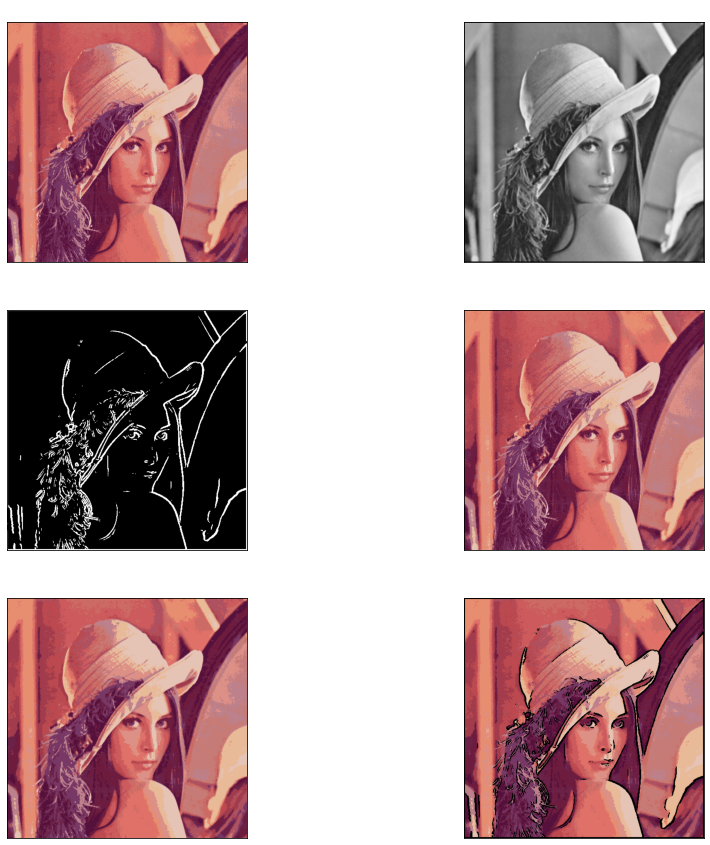

In [ ]:
image = cv.imread("lenna.png")
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

# Grayscale
grayImage = grayscale(image)

# Blur
blurredImage = blur(grayImage, 3)

# Sobel detector
edges = sobel(blurredImage)

# Median cut
reducedImage = medianCut(image)

# Median Filter
medianFiltered = medianFilter(reducedImage, 3)

# Final
finalOutput = combineImage(edges, medianFiltered)

plt.rcParams['figure.figsize']=(15,15)
fig = plt.figure()

# Imaginea originala
fig_orgl = fig.add_subplot(321)
fig_orgl.set_title('Imagine originala', color='white')
fig_orgl.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
fig_orgl.imshow(image,cmap='gray')

# Imaginea blurata
gray = fig.add_subplot(322)
gray.set_title('Imagine blurata', color='white')
gray.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
gray.imshow(blurredImage,cmap='gray')

# Imaginea cu limite
gray = fig.add_subplot(323)
gray.set_title('Filtrul Sobel', color='white')
gray.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
gray.imshow(edges,cmap='gray')

# Imaginea dupa median cut
gray = fig.add_subplot(324)
gray.set_title('Median cut', color='white')
gray.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
gray.imshow(reducedImage,cmap='gray')

# Imaginea dupa median filter
gray = fig.add_subplot(325)
gray.set_title('Median Filter', color='white')
gray.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
gray.imshow(medianFiltered,cmap='gray')

# Rezultat final
gray = fig.add_subplot(326)
gray.set_title('Final', color='white')
gray.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
gray.imshow(finalOutput,cmap='gray')